### Examples of interacting with cv2.aruco 

This notebook is useful for exploring markers in a given dictionary, what boards would look like, and how large objects would appear on a board. 

Do NOT use the output of this notebook when printing a calibration target -- any target that appears in a bagfile should have its own script to create it.

In [1]:
import copy
import os

import cv2
import cv2.aruco

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np

import charuco_stereo_calibration
import charuco_stereo_calibration.calibration as calibration
import charuco_stereo_calibration.plot_calibration as plot_calibration

In [2]:
fig_dir = "figs"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [25]:
# Going with predefined dictionary
aruco_dict_name = cv2.aruco.DICT_4X4_1000
aruco_dictionary = cv2.aruco.getPredefinedDictionary(aruco_dict_name)

In [22]:
np.reshape(fiducial_ids, [-1, 3])

array([[ 5,  6,  7],
       [ 8,  9, 11],
       [12, 13, 14],
       [15, 19, 21],
       [23, 24, 25],
       [26, 28, 29],
       [30, 31, 32]])

In [27]:
type(aruco_dictionary)

cv2.aruco_Dictionary

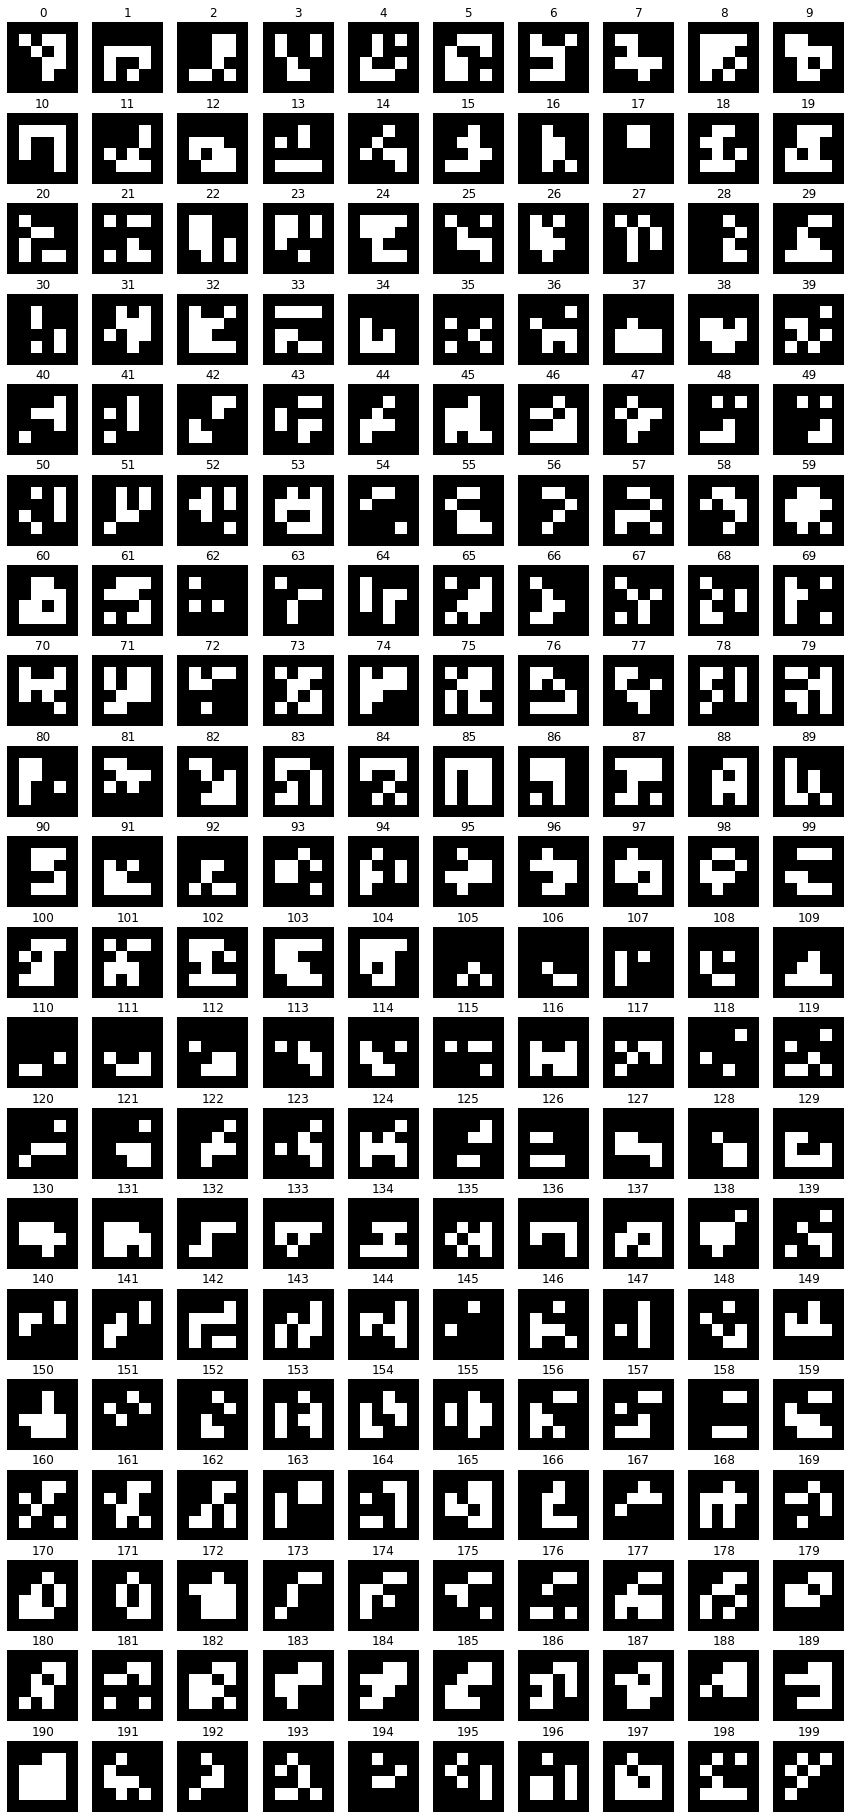

In [24]:
# Plot the original set of markers!
plot_calibration.plot_aruco_markers(aruco_dictionary, fig_dir, 20, 10)

In [5]:
# These are indexes into the predefined 4x4 dictionary
# The board grabs markers in row-major order from the input dictionary
# This list is manually generated to include only markers where the center can be identified
# and to exclude known problematic markers.
# TODO: If we need more than these tags, go ahead and automate the whitelisting of tags
#    based on there being an identifiable center (e.g. at least one of the 4 central squares needs
#    both of its neighbors to be different)
good_markers = [0, 3, 4, 5, 6, 7, 8, 9, 
                11, 12, 13, 14, 15, 19, 
                21, 23, 24, 25, 26, 28, 29, 
                30, 31, 32, 33, 34, 35, 38, 
                42, 43, 44, 46, 47, 48,
                51, 56, 58,
                60, 62, 63, 65, 66, 67, 68, 69,
                70, 72, 73, 74, 75, 76, 78, 79,
                80, 81, 82, 83, 84, 86, 87, 88,
                91, 92, 94, 95, 96, 97, 99,
                100, 101, 103, 104, 105, 106, 107, 108, 109,
                112, 114, 115, 117, 119,
                122, 124, 125, 126, 127, 128, 129,
                132, 133, 134, 135, 137, 139,
                140, 143, 144, 148, 149, 
                150, 151, 152, 153, 154, 156, 157,
                160, 161, 162, 163, 165, 166, 168, 169]

In [6]:
### THIS FUNCTION HAS BEEN COPIED TO CALIBRATION.PY

# I haven't been able to figure out how to get just the bits of the central markers, but
# drawMarker() comes the closest -- it inclues the border bit, but that's fine.
# 
# The requirement for being a "good" marker is that we can easily pick out the very center of the
# marker, which means that in the central square of 4 pixels, at least one of the diagonals has the same 
# color, while one of the off-diagonal squares is different.
def is_good_marker(aruco_dict, idx):
    # NB: This is assuming that we have a single border bit; I'm not sure how else to get
    #     the minimal representation of the marker
    # NB: I _wanted_ to find the canonical representation of the marker, but couldn't figure out 
    #     how to get that, so we're drawing it into as small a matrix as possible, and using the
    #     central pixels to determine "goodness". 
    #    (I can't figure out how to get getBitsFromByteList to work)
    ms = aruco_dict.markerSize
    try:
        matrix = aruco_dict.drawMarker(idx, ms+2)
    except Exception as ex:
        print("Could not draw marker assuming single border bit.")
        raise(ex)

    # If it doesn't have an even number of pixels, then there won't be a clear corner
    # in the exact center of the marker
    if aruco_dict.markerSize % 2 != 0:
        print("WARNING: NO marker with an odd number of pixels can be considered good")
        return False
    
    rr = int(aruco_dict.markerSize / 2)
    UL = matrix[rr][rr]
    UR = matrix[rr][rr+1]
    LL = matrix[rr+1][rr]
    LR = matrix[rr+1][rr+1]
    #print("{}: {} \n {}: {}, {}, {}, {}".format(idx, matrix, idx, UL, UR, LL, LR))
    if (LL == UR and ((LL != UL) or (LL != LR))):
        return True
    elif (UL == LR and ((UL != LL) or (UL != UR))):
        return True
    else:
        return False

In [7]:
auto_good_markers = [ii for ii in range(len(aruco_dictionary.bytesList))
                   if charuco_stereo_calibration.calibration.is_good_marker(aruco_dictionary, ii)]
print(auto_good_markers)

[0, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 19, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 42, 43, 44, 46, 47, 48, 51, 56, 58, 60, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 91, 92, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 112, 114, 115, 117, 119, 122, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 137, 139, 140, 143, 144, 148, 149, 150, 151, 152, 153, 154, 156, 157, 160, 161, 162, 163, 165, 166, 168, 169, 174, 176, 177, 179, 180, 181, 182, 183, 185, 187, 188, 192, 195, 196, 197, 198, 199, 201, 202, 204, 205, 207, 208, 209, 212, 213, 214, 215, 217, 218, 219, 220, 224, 226, 227, 228, 230, 231, 232, 234, 239, 240, 242, 243, 244, 246, 249]


In [8]:
# Checking my work ...
# Yup! 37 and 71 should have been classified as "good", so my automatic calculation works!
# (The problematic 17 doesn't need to be manually flagged since it also fails this basic test.)
for mm in good_markers:
    if mm not in auto_good_markers:
        print("Marker {} was manually labeled good but isn't in the auto-detected list!".format(mm))

for mm in auto_good_markers:
    if mm not in good_markers:
        print("Marker {} was is in the auto-detected list, but wasn't manually labeled!".format(mm))


Marker 37 was is in the auto-detected list, but wasn't manually labeled!
Marker 71 was is in the auto-detected list, but wasn't manually labeled!
Marker 174 was is in the auto-detected list, but wasn't manually labeled!
Marker 176 was is in the auto-detected list, but wasn't manually labeled!
Marker 177 was is in the auto-detected list, but wasn't manually labeled!
Marker 179 was is in the auto-detected list, but wasn't manually labeled!
Marker 180 was is in the auto-detected list, but wasn't manually labeled!
Marker 181 was is in the auto-detected list, but wasn't manually labeled!
Marker 182 was is in the auto-detected list, but wasn't manually labeled!
Marker 183 was is in the auto-detected list, but wasn't manually labeled!
Marker 185 was is in the auto-detected list, but wasn't manually labeled!
Marker 187 was is in the auto-detected list, but wasn't manually labeled!
Marker 188 was is in the auto-detected list, but wasn't manually labeled!
Marker 192 was is in the auto-detected l

### We need lists of markers that we've used on fiducials and on boards; I think I'll have to keep them manually updated :-\

In [9]:
# These are the ones that we already ordered.
# TODO: Check these in the tank before ordering anything based off of this!
fiducial_ids = [5,6,7,8,9,11,12,13,14,15,19,21,23,24,25,26,28,29,30,31,32]

In [10]:
with open("fiducial_tags.txt", "w") as fp:
    for tag_id in fiducial_ids:
        fp.write("{}\n".format(tag_id))

In [19]:
fiducial_ids

[5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 19, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32]

In [30]:
11*15*0.5

82.5

Next, we need a whitelist for the various charuco boards to draw from.

A common board is 11x8, which requires 44 unique tags.
Our plinths are 11x11 (requiring 60) and 9x12 (requiring 54)

I assume that it's fine to just pull tags in order from the list (and we don't have to worry about neighboring tags being more similar).

In [33]:
13*17*0.5

110.5

In [34]:
# NB: The *ordering* of plinth_ids matters, because that's the order that will be used when
#    creating the board. So, need to append onto the existing file, rather than overwriting.
plinth_ids = []
for tag_id in range(len(aruco_dictionary.bytesList)):
    # Go ahead and reserve a few extra early-ish ones for the wall tags
    if tag_id < 50:
        continue
    if len(plinth_ids) >= 115:
        break
    if tag_id in fiducial_ids:
        continue
    if not calibration.is_good_marker(aruco_dictionary, tag_id):
        continue
    plinth_ids.append(tag_id)
    
    

In [35]:
np.array(plinth_ids)

array([ 51,  56,  58,  60,  62,  63,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,
        87,  88,  91,  92,  94,  95,  96,  97,  99, 100, 101, 103, 104,
       105, 106, 107, 108, 109, 112, 114, 115, 117, 119, 122, 124, 125,
       126, 127, 128, 129, 132, 133, 134, 135, 137, 139, 140, 143, 144,
       148, 149, 150, 151, 152, 153, 154, 156, 157, 160, 161, 162, 163,
       165, 166, 168, 169, 174, 176, 177, 179, 180, 181, 182, 183, 185,
       187, 188, 192, 195, 196, 197, 198, 199, 201, 202, 204, 205, 207,
       208, 209, 212, 213, 214, 215, 217, 218, 219, 220, 224])

In [16]:
with open("plinth_tags.txt", "w") as fp:
    for tag_id in plinth_ids:
        fp.write("{}\n".format(tag_id))

### Now, trying to create a charuco taret

In [17]:
ncols = 9
nrows = 9 
checker_size = 0.045  # 0.02 for 8.5 x 11
aruco_size = 0.75 * checker_size
charuco_board = cv2.aruco.CharucoBoard_create(ncols, nrows, checker_size, 
                                              aruco_size, aruco_dictionary)

In [28]:
type(charuco_board)

cv2.aruco_CharucoBoard

plot_charuco_board, with checker_pixels = 531
Checkerboard has a margin of 621, 621 compared to board size
resulting board axis: [0.0575, 0.0575, 0.885, 0.885]
[(0.75, 0.75), (4.875, 0.75), (9.0, 0.75), (13.125, 0.75), (17.25, 0.75), (0.75, 17.25), (4.875, 17.25), (9.0, 17.25), (13.125, 17.25), (17.25, 17.25), (0.75, 6.25), (0.75, 11.75), (17.25, 6.25), (17.25, 11.75)]


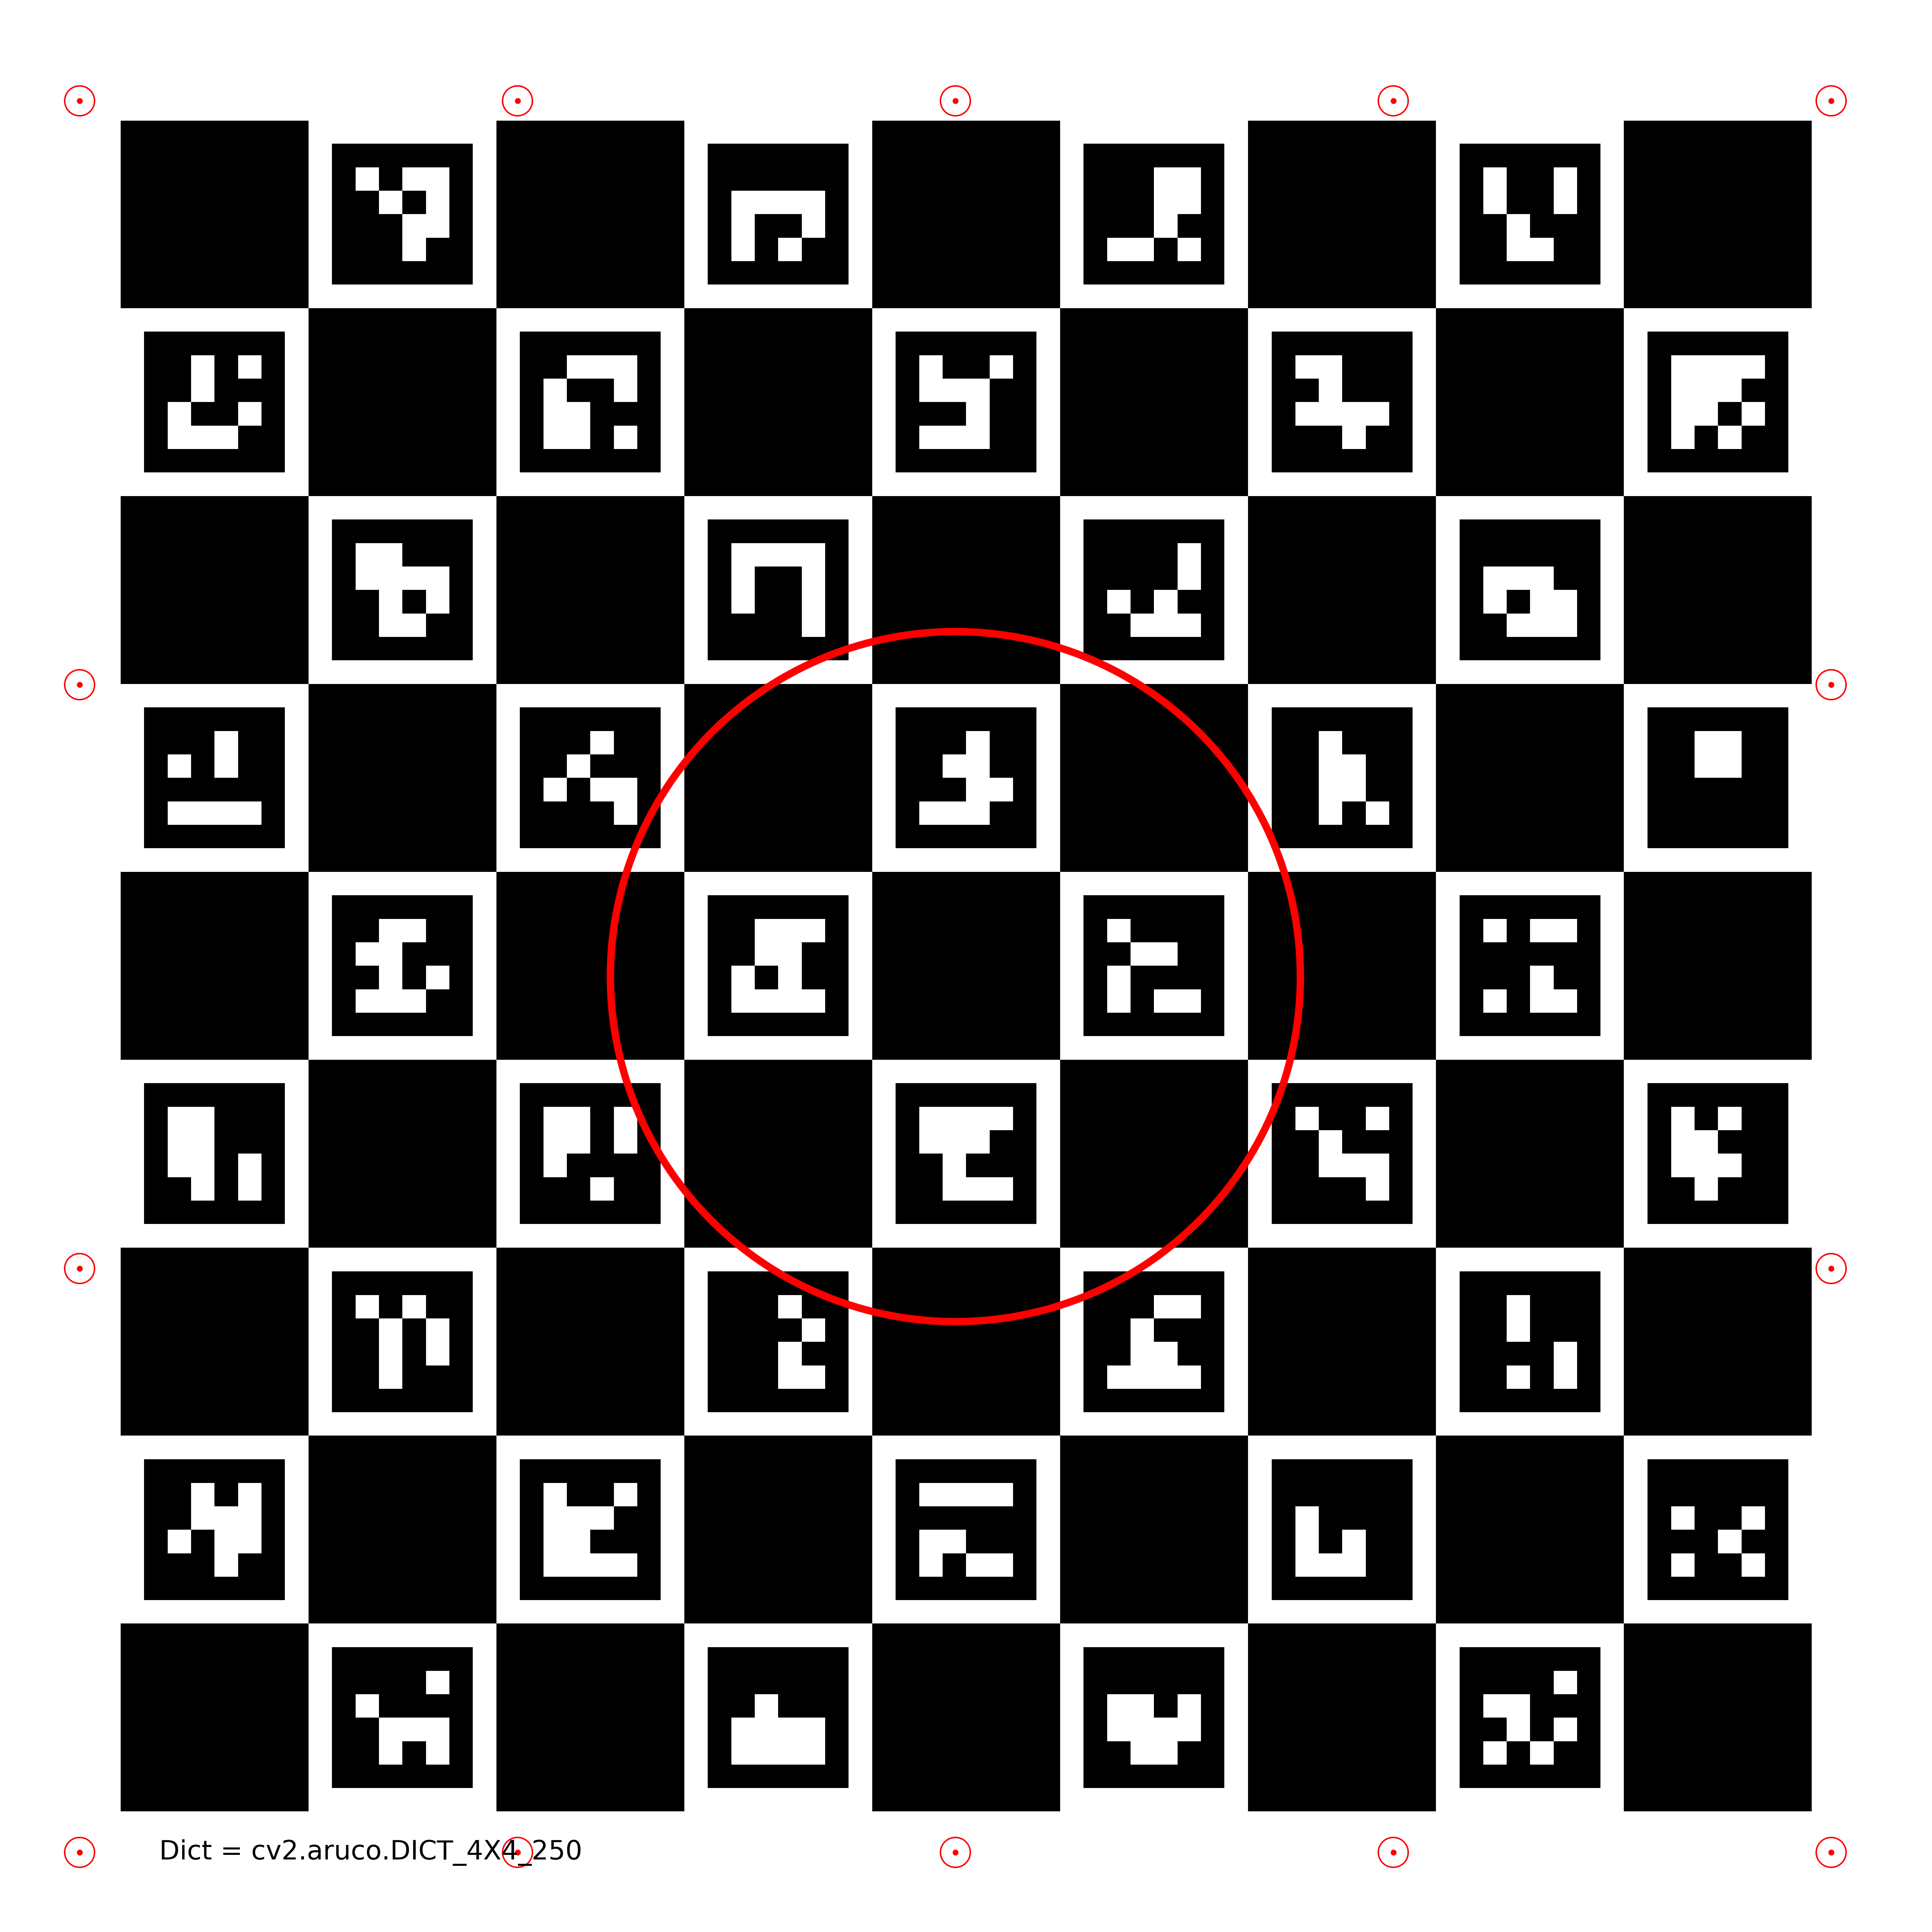

In [18]:
inches_per_meter = 39.3701
dpi = 300
# TODO: get the actual sign size! IIRC, 24x18?
# QUESTION: What happens when I run an imshow for the wrong number of pixels for the axis?
fig_width = 18  # 11 for 8.5 x 11
fig_height = 18  # 8 for 8.5 x 11
checker_pixels = int(checker_size * inches_per_meter * dpi)
print("plot_charuco_board, with checker_pixels = {}".format(checker_pixels))
board_img = charuco_board.draw((ncols*checker_pixels, 
                                nrows*checker_pixels),
                               marginSize=0)
fig = plt.figure(figsize=[fig_width, fig_height], dpi=dpi)

# TODO: board_img won't be quite the right size/shape. Center it on the figure
x_margin = fig_width * dpi - board_img.shape[1]
y_margin = fig_height * dpi - board_img.shape[0]
x0 = 0.5 * x_margin/(fig_width*dpi)
y0 = 0.5 * y_margin/(fig_height*dpi)
dx = board_img.shape[1] / (fig_width*dpi)
dy = board_img.shape[0] / (fig_height*dpi)
print("Checkerboard has a margin of {}, {} compared to board size".format(x_margin, y_margin))
print("resulting board axis: [{}, {}, {}, {}]".format(x0, y0, dx, dy))

board_ax = fig.add_axes([x0, y0, dx, dy])
board_ax.axis('off')
board_ax.imshow(board_img, cmap='gray', aspect='equal', interpolation='none')

# For this section, we'll work in figure coordinates, in inches
# want drill holes centered on 80/20, which is 1.5" wide
# TODO: Double-check the width!
drill_x1 = 0.75
drill_x2 = fig_width - 0.75
drill_y1 = 0.75
drill_y2 = fig_height - 0.75
# Want 4 holes along height, 5 along width
n_vert_holes = 4
n_horiz_holes = 5
dx = (drill_x2 - drill_x1) / (n_horiz_holes - 1)
dy = (drill_y2 - drill_y1) / (n_vert_holes - 1)
    
# Top/bottom rows
drill_coords = [(xx, drill_y1) for xx in np.arange(drill_x1, drill_x2 + 0.01, dx)]
drill_coords.extend([(xx, drill_y2) for xx in np.arange(drill_x1, drill_x2 + 0.01, dx)])
# sides
drill_coords.extend([(drill_x1, yy) for yy in np.arange(drill_y1+dy, drill_y2, dy)])
drill_coords.extend([(drill_x2, yy) for yy in np.arange(drill_y1+dy, drill_y2, dy)])

print(drill_coords)

drill_ax = fig.add_axes([0,0,1,1])
drill_ax.axis('off')

for (xx, yy) in drill_coords:
    drill_ax.plot(xx, yy, 'r.', transform=fig.dpi_scale_trans)
    #drill_ax.text(xx, yy, "({:0.2f}, {:0.2f})".format(xx,yy), color='k', 
    #        transform=fig.dpi_scale_trans,
    #        verticalalignment='top',
    #        horizontalalignment='center',
    #        fontsize=16)
    
    # TODO: What radius hole do we want for the bolt heads?
    # Assuming a 1/4" bolt (IIRC, they're 1/4-20), we want 1/4 + 1/32 = 9/32 diameter
    circ = mpatches.Circle((xx, yy), 9.0/64, transform=fig.dpi_scale_trans,
                           edgecolor='r', facecolor='none')
    drill_ax.add_patch(circ)

drill_ax.text(1.5, 0.75, "Dict = cv2.aruco.DICT_4X4_250",
             transform=fig.dpi_scale_trans,
             fontsize=18, verticalalignment='center', horizontalalignment='left')
#drill_ax.text(1.5, 0.3, "Markers = {}".format(good_markers[0:int(0.5*nrows*ncols)]),
#              transform=fig.dpi_scale_trans,
#              fontsize=14, verticalalignment='center', horizontalalignment='left')                                             

mr_easter = mpatches.Circle((0.5 * fig_width, 0.5 * fig_height), 3.25, transform=fig.dpi_scale_trans,
                           edgecolor='r', facecolor='none', linewidth=5)
drill_ax.add_patch(mr_easter)
#
#mr_easter2 = mpatches.Circle((0.5 * fig_width, 0.5 * fig_height), 5.75, transform=fig.dpi_scale_trans,
#                           edgecolor='r', facecolor='none', linewidth=5)
#drill_ax.add_patch(mr_easter2)

plt.savefig("{}/charuco_board_8x11.pdf".format(fig_dir)) # , bbox_inches='tight')
